## LOG
#### [10/05/2020] 
- progress: completing training loop
- issues: TrainEvalCallback turns model into eval mode. It is not desired because torchvision.FasterRCNN has different behavior at eval mode
- issues: friction integrating metrics into the training loop
- issues: default datablock is not really suitable for torchvision.FasterRCNN

In [1]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

import warnings 
warnings.filterwarnings("ignore")

from fastai2.vision.all import *

from src.data.dls import build_dataloaders
from src.metrics.map import calculate_image_precision
from src.model.FasterRCNN import get_faster_rcnn

%load_ext autoreload
%autoreload 2

In [2]:
from pdb import set_trace

#### 0. Testing TensorBBox

In [3]:
bbox = TensorBBox.create([10, 10, 100, 150], img_size = 256)
tfms = PointScaler()
enc = tfms(bbox)
enc

TensorBBox([[-0.9219, -0.9219, -0.2188,  0.1719]])

In [4]:
encs = torch.stack([enc[0] for i in range(5)])
encs

tensor([[-0.9219, -0.9219, -0.2188,  0.1719],
        [-0.9219, -0.9219, -0.2188,  0.1719],
        [-0.9219, -0.9219, -0.2188,  0.1719],
        [-0.9219, -0.9219, -0.2188,  0.1719],
        [-0.9219, -0.9219, -0.2188,  0.1719]])

In [5]:
TensorPoint((encs + 1) * tensor(256).float()/2, img_size = 256)

TensorPoint([[ 10.,  10., 100., 150.],
        [ 10.,  10., 100., 150.],
        [ 10.,  10., 100., 150.],
        [ 10.,  10., 100., 150.],
        [ 10.,  10., 100., 150.]])

#### 1. Get DataLoaders

In [6]:
data_path = '/userhome/34/h3509807/wheat-data'

In [7]:
dls = build_dataloaders(
    data_path, bs = 8, resize_sz = 256, 
    norm = False, rand_seed = 144
    )

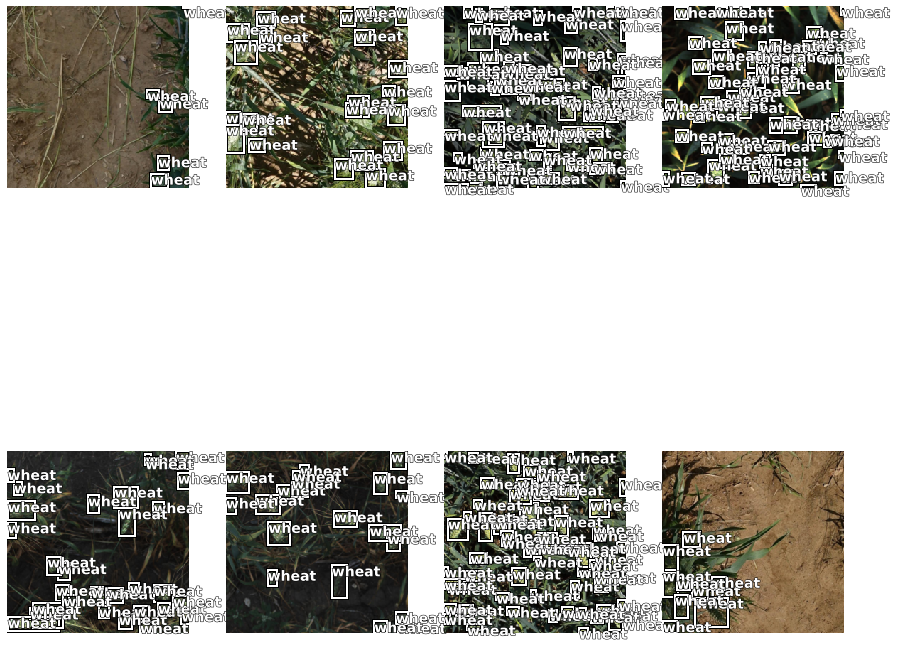

In [8]:
dls.show_batch(figsize = (15, 15))

In [9]:
# batch = (TensorImage, TensorBBox, TensorMultiCategory)
# TensorBBox: [BS, MAX BBOX NUMBER, 4]
# TensorMultiCategory: [BS, MAX BBOX NUMBER]
b = dls.one_batch()
type(b), type(b[0]), type(b[1]), type(b[2])

(tuple,
 fastai2.torch_core.TensorImage,
 fastai2.vision.core.TensorBBox,
 fastai2.torch_core.TensorMultiCategory)

In [10]:
b[0].shape, b[1].shape, b[2].shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 70, 4]), torch.Size([8, 70]))

In [11]:
b[0][0, 0, :3, :3]

tensor([[0.0980, 0.0863, 0.0824],
        [0.0941, 0.0627, 0.0588],
        [0.0863, 0.0510, 0.0392]], device='cuda:0')

In [12]:
b[1][0][0]

tensor([ 0.4824, -1.0000,  0.5996, -0.8242], device='cuda:0')

#### 2. Setup Model

In [13]:
model = get_faster_rcnn()

#### 3. Setup Dummy Loss Function

In [14]:
import torch
import torch.nn as nn

In [15]:
class WeightedMultiLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, preds, tgts, **kwargs):
        loss = 0.
        for _, ind_loss in preds.items():
            loss += ind_loss
        return loss

In [16]:
multi_loss = WeightedMultiLoss()

In [17]:
isinstance(multi_loss, nn.Module)

True

#### 4. Freezing Selected Layers
- model.backbone
- model.rpn
- model.roi_heads

In [18]:
isinstance(model.roi_heads, nn.Module)

True

In [19]:
def _faster_rcnn_split(m):
    return L(m.backbone, m.rpn, m.roi_heads).map(params)

#### 5. Setup Metrics

In [20]:
from functools import partial

In [21]:
thresholds = [i for i in map(lambda i: i/100, range(50, 80, 5))]
thresholds

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

In [22]:
map_getter = partial(calculate_image_precision, thresholds = thresholds)

#### 6. Setup Callback
- begin_batch: rearange target from tensor to list of dict
- after_pred: sort predicted bboxes by confidence score (descending order)

In [23]:
class EssentialCallback(Callback):
    """ 
    essential changes for fastai2 Learner to interface with torchvision FasterRCNN 
    """
    def __init__(self, img_size):
        self.img_size = img_size
        
    def _decode_bboxs(self, enc_bboxs):
        sz = self.img_size
        return TensorPoint((enc_bboxs + 1)*tensor(256).float()/2, img_size = sz)
    
    def begin_batch(self):
        """ 
        re-arrange both self.learn.yb and self.learn.xb format
        self.learn.yb = [{'boxes': tensor(BS, 4), 'labels': tensor(BS)}, ...] 
        """
        # tupify, listify self.learn.xb
        self.learn.xb = ([x for x in self.learn.xb[0]], ) 
        
        # tupify, listify, dictionarize yb
        bboxs_b, cats_b = self.learn.yb
        
        yb = []
        for bboxs, cats in zip(bboxs_b, cats_b):
            idxs = torch.where(cats != 0)
            tmp_dict = {'boxes': self._decode_bboxs(bboxs[idxs]), 
                        'labels': cats[idxs]}
            yb.append(tmp_dict)
        
        self.learn.yb = (yb,)
        return None

#### 7. Setup Learner

In [24]:
class WheatLearner(Learner):
    def one_batch(self, i, b):
        self.iter = i
        try:
            self._split(b);                                  self('begin_batch')
            
            # model(self.xb, self.yb) = loss
            self.pred = self.model(*self.xb, *self.yb);     self('after_pred')
                
            if len(self.yb) == 0: return
            
            self.loss = self.loss_func(self.pred, *self.yb);self('after_loss')
            if not self.training: return
            self.loss.backward();                            self('after_backward')
            self.opt.step();                                 self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

In [25]:
learn = WheatLearner(dls, model, 
                     loss_func = multi_loss, 
                     splitter = _faster_rcnn_split,
                     #metrics = map_getter,
                     cbs = EssentialCallback(img_size = 256))

#### 8. Find Optimal Learning Rate

In [26]:
#learn.lr_find()

#### 9. Train + Unfreeze All Layers Except Backbone

In [27]:
learn.fit(n_epoch = 1, lr = 0.0001)

epoch,train_loss,valid_loss,time
0,0.692699,0.727647,06:47


AttributeError: 'list' object has no attribute 'items'

In [28]:
%debug

> <ipython-input-15-a838aab07b81>(7)forward()
      5     def forward(self, preds, tgts, **kwargs):
      6         loss = 0.
----> 7         for _, ind_loss in preds.items():
      8             loss += ind_loss
      9         return loss

ipdb> u
> /userhome/31/h3509807/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/modules/module.py(532)__call__()
    530             result = self._slow_forward(*input, **kwargs)
    531         else:
--> 532             result = self.forward(*input, **kwargs)
    533         for hook in self._forward_hooks.values():
    534             hook_result = hook(self, input, result)

ipdb> u
> <ipython-input-24-d3e76b963cf8>(12)one_batch()
     10             if len(self.yb) == 0: return
     11 
---> 12             self.loss = self.loss_func(self.pred, *self.yb);self('after_loss')
     13             if not self.training: return
     14             self.loss.backward();                            self('after_backward')

ipdb> self.model(*self

ipdb> self.model
FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d

ipdb> self.mode.training
*** AttributeError: 'WheatLearner' object has no attribute 'mode'
ipdb> self.model.training
False
ipdb> exit


In [ ]:
# learn.create_opt()
# learn.opt.freeze_to(-1) # freeze except last param groups
# learn.opt.param_groups[-1]
# learn.opt.freeze_to(-2) # freeze except last two param groups
# learn.opt.param_groups[-2]